# Objetivo: Reduzir a dimensionalidade dos dados
correlacionar as colunas da base de dados

### Tratamento da base de dados

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import io

In [5]:
df_credit = pd.read_csv('../data/credit_card_clients.csv', header = 1)
df_credit

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000,1,3,1,39,0,0,0,0,...,88004,31237,15980,8500,20000,5003,3047,5000,1000,0
29996,29997,150000,1,3,2,43,-1,-1,-1,-1,...,8979,5190,0,1837,3526,8998,129,0,0,0
29997,29998,30000,1,2,2,37,4,3,2,-1,...,20878,20582,19357,0,0,22000,4200,2000,3100,1
29998,29999,80000,1,3,1,41,1,-1,0,0,...,52774,11855,48944,85900,3409,1178,1926,52964,1804,1


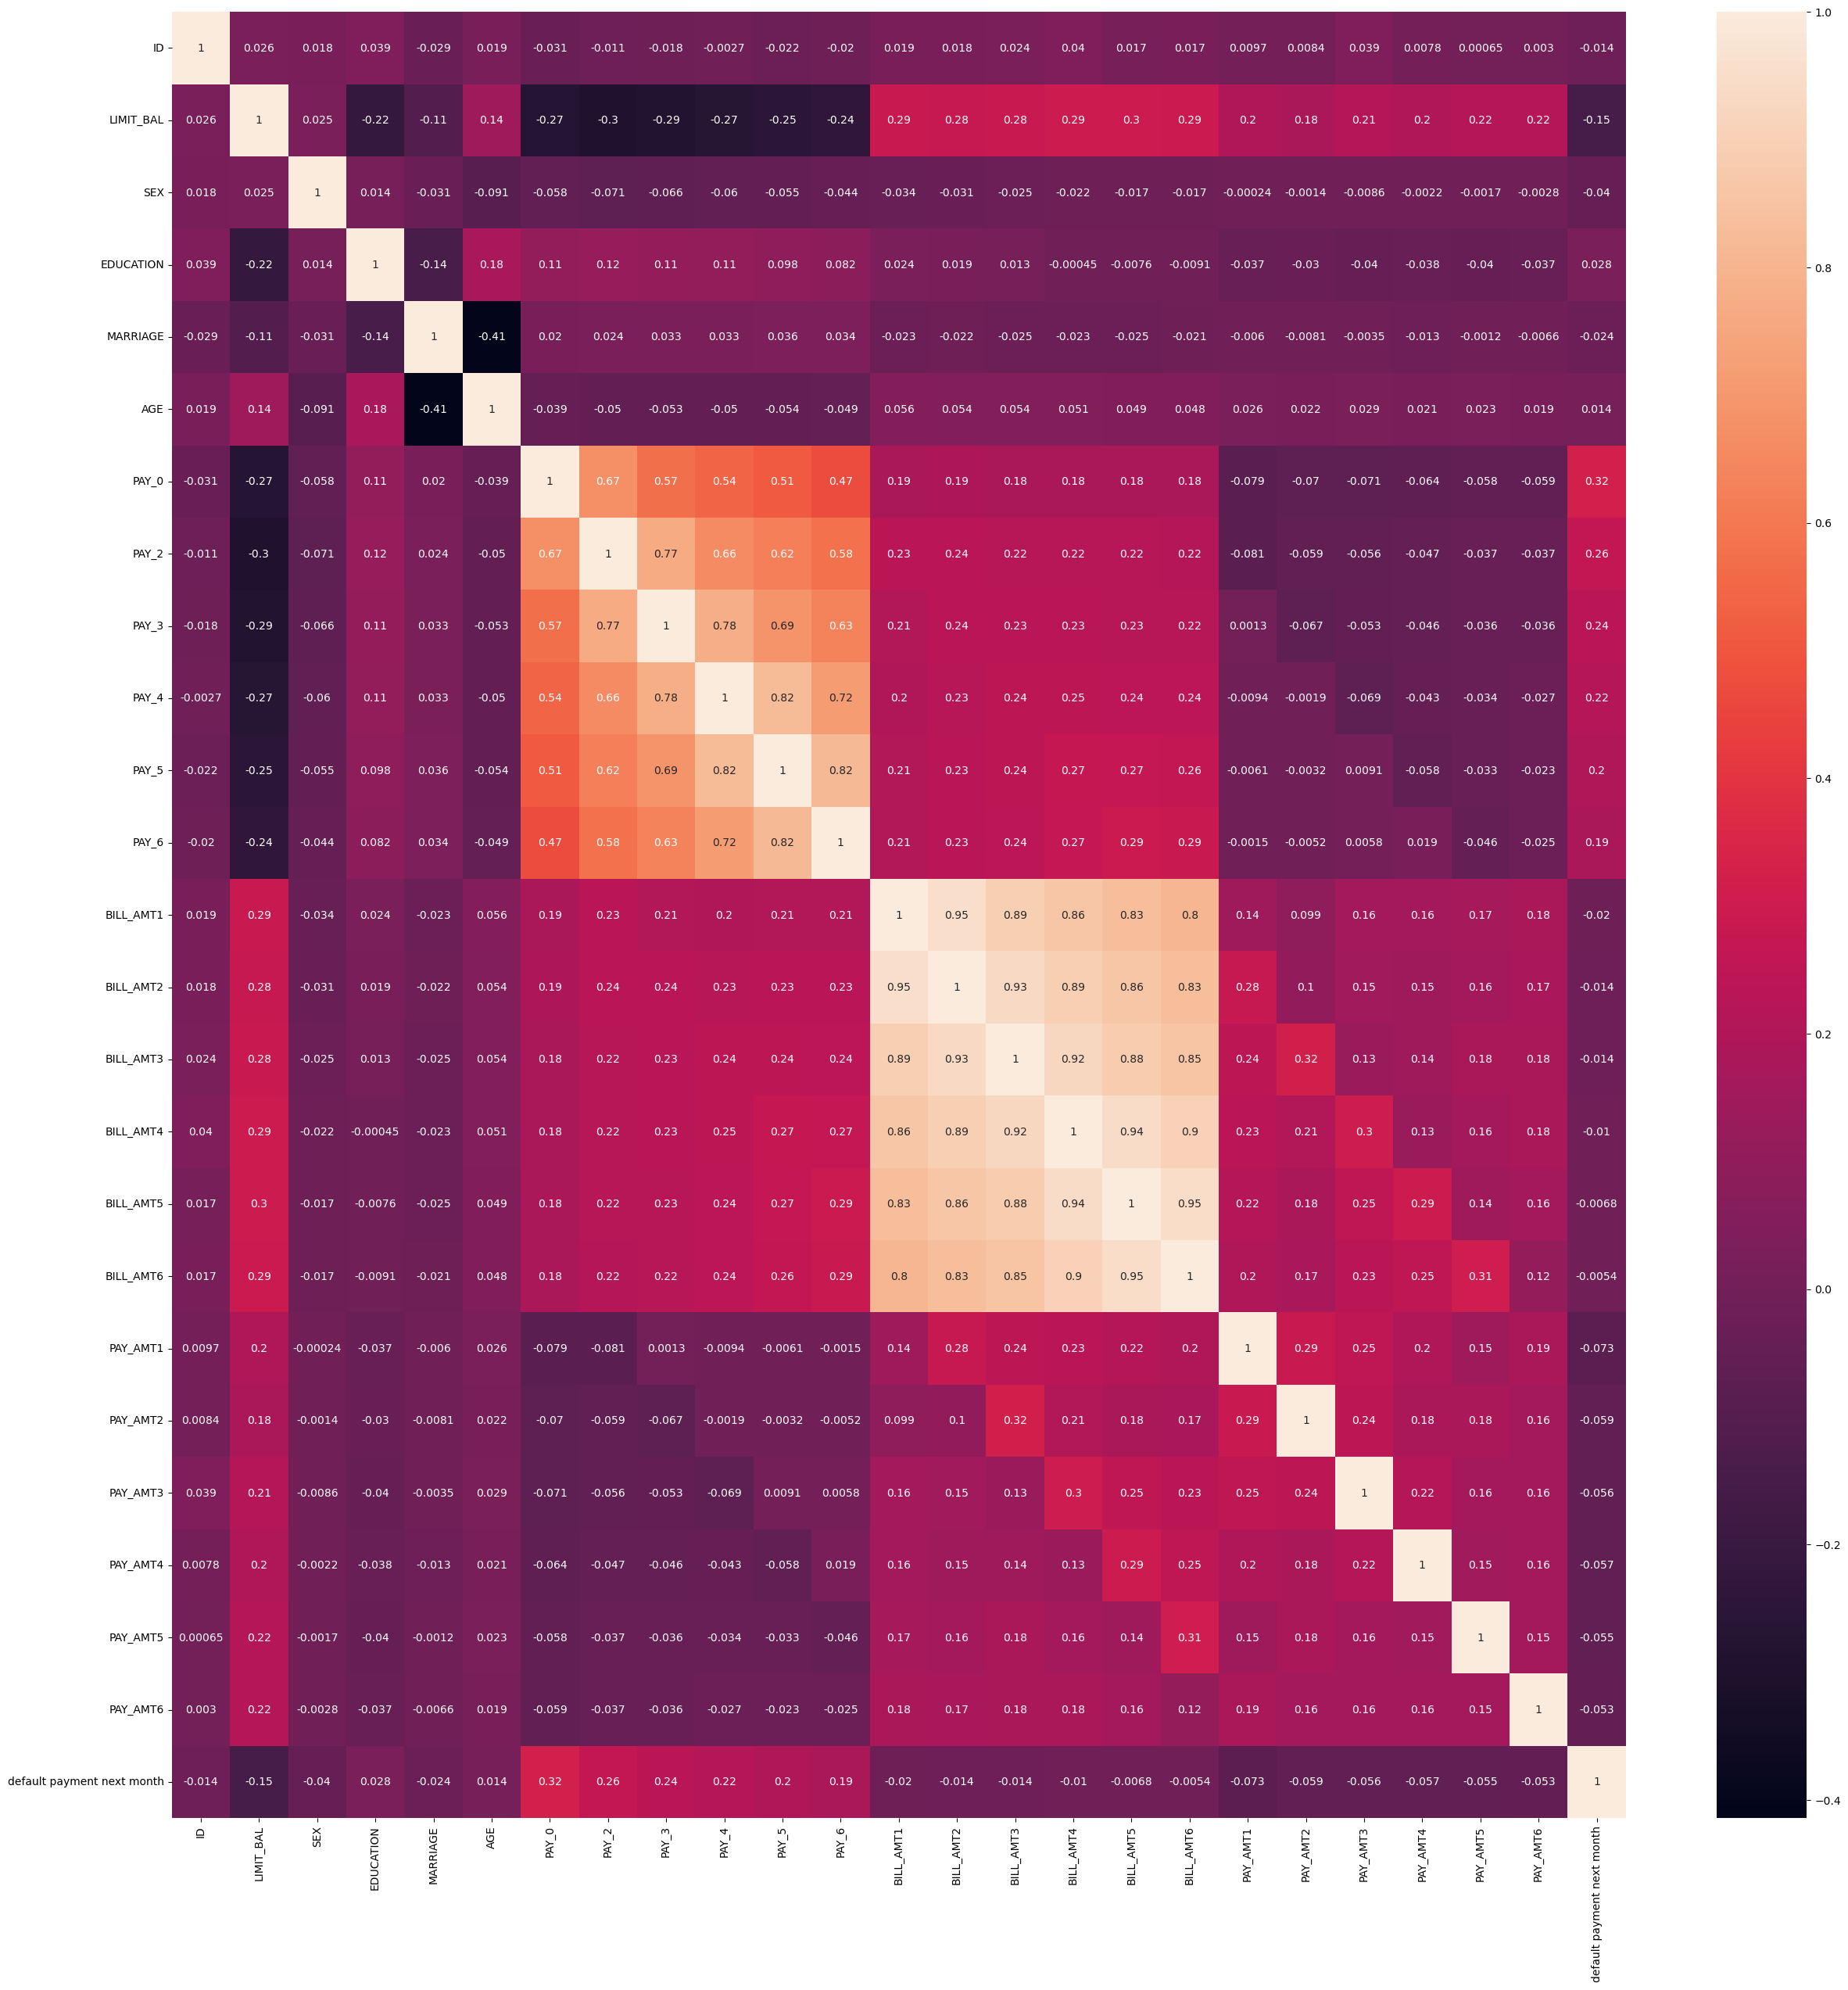

In [6]:
fig = plt.figure(figsize=(30,30))
sns.heatmap(df_credit.corr(), annot=True);

In [7]:
df_credit.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')

In [9]:
X = df_credit.iloc[:, 1:len(df_credit.columns)].values
X.shape

(30000, 24)

In [10]:
X = np.array(X).astype('float32')
X[0]

array([ 2.000e+04,  2.000e+00,  2.000e+00,  1.000e+00,  2.400e+01,
        2.000e+00,  2.000e+00, -1.000e+00, -1.000e+00, -2.000e+00,
       -2.000e+00,  3.913e+03,  3.102e+03,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  6.890e+02,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  1.000e+00], dtype=float32)

### COnfigurações do SageMaker

In [11]:
import sagemaker
import boto3
from sagemaker import Session

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [12]:
session = sagemaker.Session()
bucket = 'aws-sagemaker-course-633'
subdir = 'models/credit-card/pca'
subdir_dataset = 'datasets/credit-card'
key_train = 'credit-card-train-data-pca'
role = sagemaker.get_execution_role()
s3_train_data = 's3://{}/{}/train/{}'.format(bucket, subdir_dataset, key_train)
output_location = 's3://{}/{}/output'.format(bucket, subdir)

In [13]:
import sagemaker.amazon.common as smac
buffer = io.BytesIO()
smac.write_numpy_to_dense_tensor(buffer, X)
buffer.seek(0)

0

In [14]:
boto3.resource('s3').Bucket(bucket).Object(os.path.join(subdir_dataset, 'train', key_train)).upload_fileobj(buffer)

### Treinamento do PCA

In [15]:
container = sagemaker.image_uris.retrieve(framework = 'pca', region = boto3.Session().region_name)

In [16]:
pca = sagemaker.estimator.Estimator(image_uri = container,
                                    role = role,
                                    instance_count = 1,
                                    instance_type = 'ml.m5.large',
                                    output_path = output_location,
                                    sagemaker_session = session)

In [17]:
pca.set_hyperparameters(feature_dim = 30000,
                        num_components = 2,
                        mini_batch_size = 200)

In [18]:
pca.fit({'train': s3_train_data})

INFO:sagemaker:Creating training-job with name: pca-2025-01-11-11-41-12-458


2025-01-11 11:41:13 Starting - Starting the training job...
2025-01-11 11:41:27 Starting - Preparing the instances for training...
2025-01-11 11:41:54 Downloading - Downloading input data...
2025-01-11 11:42:19 Downloading - Downloading the training image......
2025-01-11 11:43:40 Training - Training image download completed. Training in progress.
2025-01-11 11:43:40 Uploading - Uploading generated training modelDocker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.8/site-packages/mxnet/model.py:97: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if num_device is 1 and 'dist' not in kvstore:
[01/11/2025 11:43:37 INFO 140683859171136] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-conf.json: {'algorithm_mode': 'regular', 'subtract_mean': 'true', 'extra_components': '-1', 'force_dense': 'true', 'epochs': 1, '_log_level': 'info', '_kvstore': 'dist_sync', '_n

### Redução de dimensionalidade

In [19]:
pca_predictor = pca.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

INFO:sagemaker:Creating model with name: pca-2025-01-11-11-51-36-798
INFO:sagemaker:Creating endpoint-config with name pca-2025-01-11-11-51-36-798
INFO:sagemaker:Creating endpoint with name pca-2025-01-11-11-51-36-798


-------!

In [20]:
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
pca_predictor.serializer = CSVSerializer()
pca_predictor.deserializer = JSONDeserializer()

In [21]:
X0_pca = pca_predictor.predict(X[0])
print(X0_pca)

{'projections': [{'projection': [75538.1875, 166488.125]}]}


In [22]:
X_pca = pca_predictor.predict(X)

In [23]:
X_pca = np.array([r['projection'] for r in X_pca['projections']])

In [24]:
X_pca, X_pca.shape

(array([[ 75538.1875   , 166488.125    ],
        [ -9780.6640625, 114226.9375   ],
        [ 33471.40625  ,  98432.3046875],
        ...,
        [ 77857.5234375, 140206.0625   ],
        [ 74908.3125   ,  41427.6875   ],
        [ 95514.140625 ,  70860.234375 ]]),
 (30000, 2))

In [25]:
X_pca = np.array(X_pca).astype('float32')

In [26]:
X_pca

array([[ 75538.19 , 166488.12 ],
       [ -9780.664, 114226.94 ],
       [ 33471.406,  98432.305],
       ...,
       [ 77857.52 , 140206.06 ],
       [ 74908.31 ,  41427.688],
       [ 95514.14 ,  70860.234]], dtype=float32)

### Treinamento de K-Means

In [27]:
subdir_kmeans = 'models/credit-card/kmeans'
output_location_kmeans = 's3://{}/{}'.format(bucket, subdir_kmeans)

In [28]:
from sagemaker import KMeans

In [29]:
kmeans = KMeans(role = role,
                instance_count = 1,
                instance_type = 'ml.m5.large',
                output_path = output_location_kmeans,
                k = 4) #valor definido pelo usuário

In [30]:
kmeans.fit(kmeans.record_set(X_pca))

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2025-01-11-12-11-22-722


2025-01-11 12:11:24 Starting - Starting the training job...
2025-01-11 12:11:38 Starting - Preparing the instances for training...
2025-01-11 12:12:08 Downloading - Downloading input data...
2025-01-11 12:12:48 Downloading - Downloading the training image......
2025-01-11 12:13:54 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[01/11/2025 12:13:58 INFO 140157740246848] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]', 'force_dense': 'true', '_disable_wait_to_read': 'false', '_enable_profiler': 'false', '_kvstore': 'auto', '

### Agrupamento com o K-Means

In [31]:
kmeans_predictor = kmeans.deploy(initial_instance_count = 1, instance_type = 'ml.m5.large')

INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating model with name: kmeans-2025-01-11-12-31-38-160
INFO:sagemaker:Creating endpoint-config with name kmeans-2025-01-11-12-31-38-160
INFO:sagemaker:Creating endpoint with name kmeans-2025-01-11-12-31-38-160


-------!

In [32]:
results = kmeans_predictor.predict(X_pca)
results

[label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 93079.0390625
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 56548.3515625
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 16804.5546875
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "distance_to_cluster"
   value {
     float32_tensor {
       values: 59556.77734375
     }
   }
 },
 label {
   key: "closest_cluster"
   value {
     float32_tensor {
       values: 1.0
     }
   }
 }
 label {
   key: "dis

In [33]:
### cluster mais próximo
labels = [r.label['closest_cluster'].float32_tensor.values[0] for r in results]

In [35]:
print(labels)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 3.0, 1.0, 0.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 3.0, 1.0, 0.0, 1.0, 2.0, 3.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 3.0, 1.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 3.0, 0.0, 3.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 3.0, 1.0, 3.0, 1.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 3.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 0.0, 3.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 3.0, 1.0, 1.0, 1.0, 3.0, 0.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0,

In [36]:
np.unique(labels, return_counts = True)

(array([0., 1., 2., 3.]), array([ 4360, 18610,  1012,  6018]))

In [37]:
df_credit.shape, len(labels)

((30000, 25), 30000)

In [38]:
df_credit['cluster'] = labels

In [39]:
df_credit.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,cluster
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,689,0,0,0,0,1,1.0
1,2,120000,2,2,2,26,-1,2,0,0,...,3455,3261,0,1000,1000,1000,0,2000,1,1.0
2,3,90000,2,2,2,34,0,0,0,0,...,14948,15549,1518,1500,1000,1000,1000,5000,0,1.0
3,4,50000,2,2,1,37,0,0,0,0,...,28959,29547,2000,2019,1200,1100,1069,1000,0,1.0
4,5,50000,1,2,1,57,-1,0,-1,0,...,19146,19131,2000,36681,10000,9000,689,679,0,1.0


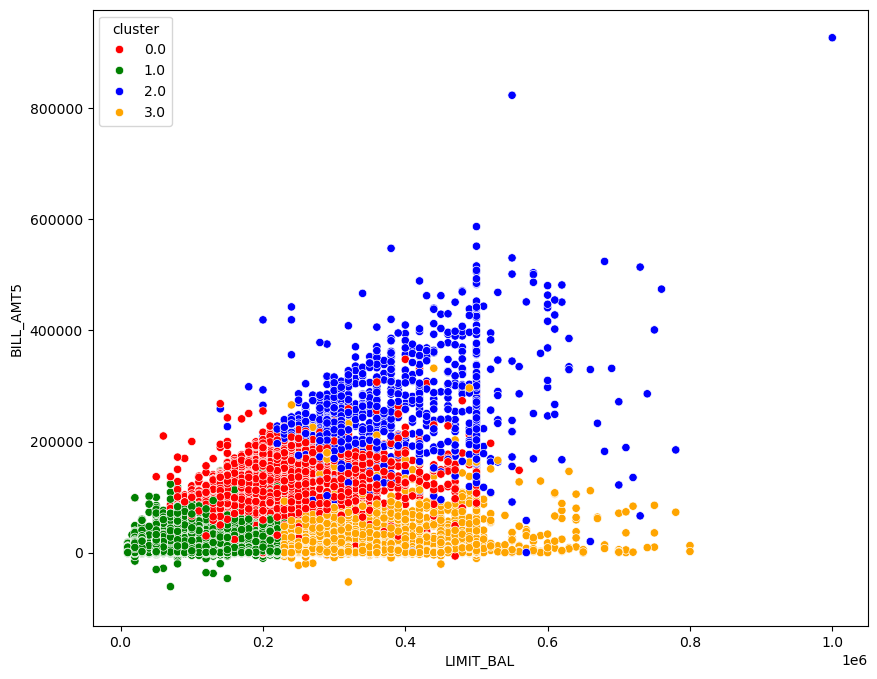

In [45]:
plt.figure(figsize=(10,8))
sns.scatterplot(x = 'LIMIT_BAL', y = 'BILL_AMT5', data = df_credit, hue = 'cluster', palette = ['red', 'green', 'blue', 'orange']);

In [47]:
df_credit_3 = df_credit[df_credit['cluster'] == 3.0]
df_credit_3.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month,cluster
11,12,260000,2,1,2,51,-1,-1,-1,-1,...,22287,13668,21818,9966,8583,22301,0,3640,0,3.0
12,13,630000,2,2,2,41,-1,0,-1,-1,...,6500,2870,1000,6500,6500,6500,2870,0,0,3.0
14,15,250000,1,1,2,29,0,0,0,0,...,56875,55512,3000,3000,3000,3000,3000,3000,0,3.0
18,19,360000,2,1,1,49,1,-2,-2,-2,...,0,0,0,0,0,0,0,0,0,3.0
23,24,450000,2,1,1,40,-2,-2,-2,-2,...,0,0,19428,1473,560,0,0,1128,1,3.0


In [48]:
df_credit_3.to_csv('base_credit_3.csv')

In [49]:
pca_predictor.delete_endpoint()
kmeans_predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pca-2025-01-11-11-51-36-798
INFO:sagemaker:Deleting endpoint with name: pca-2025-01-11-11-51-36-798
INFO:sagemaker:Deleting endpoint configuration with name: kmeans-2025-01-11-12-31-38-160
INFO:sagemaker:Deleting endpoint with name: kmeans-2025-01-11-12-31-38-160
